In [1]:
import numpy as np
import pandas as pd

import torch
import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from matplotlib import pyplot as plt
%matplotlib inline
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

Files already downloaded and verified


In [3]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=10, shuffle=False)


classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

foreground_classes = {'plane', 'car', 'bird'}
#foreground_classes = {'bird', 'cat', 'deer'}
background_classes = {'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'}
#background_classes = {'plane', 'car', 'dog', 'frog', 'horse','ship', 'truck'}

fg1,fg2,fg3 = 0,1,2

In [4]:
dataiter = iter(trainloader)
background_data=[]
background_label=[]
foreground_data=[]
foreground_label=[]
batch_size=10

for i in range(5000):
  images, labels = dataiter.next()
  for j in range(batch_size):
    if(classes[labels[j]] in background_classes):
      img = images[j].tolist()
      background_data.append(img)
      background_label.append(labels[j])
    else:
      img = images[j].tolist()
      foreground_data.append(img)
      foreground_label.append(labels[j])
            
foreground_data = torch.tensor(foreground_data)
foreground_label = torch.tensor(foreground_label)
background_data = torch.tensor(background_data)
background_label = torch.tensor(background_label)

In [5]:
def create_mosaic_img(bg_idx,fg_idx,fg): 
  """
  bg_idx : list of indexes of background_data[] to be used as background images in mosaic
  fg_idx : index of image to be used as foreground image from foreground data
  fg : at what position/index foreground image has to be stored out of 0-8
  """
  image_list=[]
  j=0
  for i in range(9):
    if i != fg:
      image_list.append(background_data[bg_idx[j]])#.type("torch.DoubleTensor"))
      j+=1
    else: 
      image_list.append(foreground_data[fg_idx])#.type("torch.DoubleTensor"))
      label = foreground_label[fg_idx]-fg1  # minus 7 because our fore ground classes are 7,8,9 but we have to store it as 0,1,2
  #image_list = np.concatenate(image_list ,axis=0)
  image_list = torch.stack(image_list) 
  return image_list,label

In [6]:
desired_num = 30000
mosaic_list_of_images =[]      # list of mosaic images, each mosaic image is saved as list of 9 images
fore_idx =[]                   # list of indexes at which foreground image is present in a mosaic image i.e from 0 to 9               
mosaic_label=[]                # label of mosaic image = foreground class present in that mosaic
for i in range(desired_num):
  np.random.seed(i)
  bg_idx = np.random.randint(0,35000,8)
  fg_idx = np.random.randint(0,15000)
  fg = np.random.randint(0,9)
  fore_idx.append(fg)
  image_list,label = create_mosaic_img(bg_idx,fg_idx,fg)
  mosaic_list_of_images.append(image_list)
  mosaic_label.append(label)

In [7]:
class MosaicDataset(Dataset):
  """MosaicDataset dataset."""

  def __init__(self, mosaic_list_of_images, mosaic_label, fore_idx):
    """
      Args:
        csv_file (string): Path to the csv file with annotations.
        root_dir (string): Directory with all the images.
        transform (callable, optional): Optional transform to be applied
            on a sample.
    """
    self.mosaic = mosaic_list_of_images
    self.label = mosaic_label
    self.fore_idx = fore_idx

  def __len__(self):
    return len(self.label)

  def __getitem__(self, idx):
    return self.mosaic[idx] , self.label[idx], self.fore_idx[idx]
batch = 250
msd = MosaicDataset(mosaic_list_of_images, mosaic_label , fore_idx)
train_loader = DataLoader( msd,batch_size= batch ,shuffle=False,num_workers=0,)

In [8]:
data,labels,fg_index = iter(train_loader).next()

In [9]:
bg = []
for i in range(120):
  torch.manual_seed(i)
  betag = torch.ones((250,9))/9  #torch.randn(250,9)
  a=bg.append( betag.requires_grad_() )

In [10]:
class Module2(nn.Module):
  def __init__(self):
    super(Module2, self).__init__()
    
    self.conv1 = nn.Conv2d(3, 6, 5)
    self.pool = nn.MaxPool2d(2, 2)
    self.conv2 = nn.Conv2d(6, 16, 5)
    self.fc1 = nn.Linear(16 * 5 * 5, 120)
    self.fc2 = nn.Linear(120, 84)
    self.fc3 = nn.Linear(84, 10)
    self.fc4 = nn.Linear(10,3)

  def forward(self,y):  #z batch of list of 9 images
    y1 = self.pool(F.relu(self.conv1(y)))
    y1 = self.pool(F.relu(self.conv2(y1)))
    y1 = y1.view(-1, 16 * 5 * 5)

    y1 = F.relu(self.fc1(y1))
    y1 = F.relu(self.fc2(y1))
    y1 = F.relu(self.fc3(y1))
    y1 = self.fc4(y1)
    return y1

In [11]:
torch.manual_seed(1234)
what_net = Module2().double()

what_net.load_state_dict(torch.load("simultaneous_what.pt"))
what_net = what_net.to("cuda")

In [12]:
def attn_avg(x,beta):
  y = torch.zeros([batch,3, 32,32], dtype=torch.float64)
  y = y.to("cuda")
  alpha = F.softmax(beta,dim=1)   # alphas
  for i in range(9):            
    alpha1 = alpha[:,i]          
    y = y + torch.mul(alpha1[:,None,None,None],x[:,i])
  return y,alpha

In [13]:
def calculate_attn_loss(dataloader,what,criter):
  what.eval()
  r_loss = 0
  alphas = []
  lbls = []
  pred = []
  fidices = []
  correct = 0
  tot = 0
  with torch.no_grad():
    for i, data in enumerate(dataloader, 0):
      inputs, labels,fidx= data
      lbls.append(labels)
      fidices.append(fidx)
      inputs = inputs.double()
      beta = bg[i]  # alpha for ith batch
      inputs, labels,beta = inputs.to("cuda"),labels.to("cuda"),beta.to("cuda")
      avg,alpha = attn_avg(inputs,beta)
      alpha = alpha.to("cuda")
      outputs = what(avg)
      _, predicted = torch.max(outputs.data, 1)
      correct += sum(predicted == labels)
      tot += len(predicted)
      pred.append(predicted.cpu().numpy())
      alphas.append(alpha.cpu().numpy())
      loss = criter(outputs, labels)
      r_loss += loss.item()
  alphas = np.concatenate(alphas,axis=0)
  pred = np.concatenate(pred,axis=0)
  lbls = np.concatenate(lbls,axis=0)
  fidices = np.concatenate(fidices,axis=0)
  #print(alphas.shape,pred.shape,lbls.shape,fidices.shape) 
  analysis = analyse_data(alphas,lbls,pred,fidices)
  return r_loss/(i+1),analysis,correct.item(),tot,correct.item()/tot

In [14]:
# for param in what_net.parameters():
#     param.requires_grad = False

In [15]:
def analyse_data(alphas,lbls,predicted,f_idx):
    '''
       analysis data is created here
    '''
    batch = len(predicted)
    amth,alth,ftpt,ffpt,ftpf,ffpf = 0,0,0,0,0,0
    for j in range (batch):
      focus = np.argmax(alphas[j])
      if(alphas[j][focus] >= 0.5):
        amth +=1
      else:
        alth +=1
      if(focus == f_idx[j] and predicted[j] == lbls[j]):
        ftpt += 1
      elif(focus != f_idx[j] and predicted[j] == lbls[j]):
        ffpt +=1
      elif(focus == f_idx[j] and predicted[j] != lbls[j]):
        ftpf +=1
      elif(focus != f_idx[j] and predicted[j] != lbls[j]):
        ffpf +=1
    #print(sum(predicted==lbls),ftpt+ffpt
    return [ftpt,ffpt,ftpf,ffpf,amth,alth]

In [16]:
optim1 = []
for i in range(120):
  optim1.append(optim.RMSprop([bg[i]], lr=0.01))

In [17]:
# instantiate optimizer
optimizer_what = optim.RMSprop(what_net.parameters(), lr=0.001)#, momentum=0.9)#,nesterov=True)


 


criterion = nn.CrossEntropyLoss()
acti = []
analysis_data_tr = []
analysis_data_tst = []
loss_curi_tr = []
loss_curi_tst = []
epochs = 100


# calculate zeroth epoch loss and FTPT values
running_loss,anlys_data,correct,total,accuracy = calculate_attn_loss(train_loader,what_net,criterion)
print('training epoch: [%d ] loss: %.3f correct: %.3f, total: %.3f, accuracy: %.3f' %(0,running_loss,correct,total,accuracy)) 
loss_curi_tr.append(running_loss)
analysis_data_tr.append(anlys_data)




# training starts 
for epoch in range(epochs): # loop over the dataset multiple times
  ep_lossi = []
  running_loss = 0.0
  what_net.train()
  for i, data in enumerate(train_loader, 0):
    # get the inputs
    inputs, labels,_  = data
    inputs = inputs.double()
    beta = bg[i] # alpha for ith batch
    inputs, labels,beta = inputs.to("cuda"),labels.to("cuda"),beta.to("cuda")
        
    # zero the parameter gradients
    optimizer_what.zero_grad()
    optim1[i].zero_grad()
      
    # forward + backward + optimize
    avg,alpha = attn_avg(inputs,beta)
    outputs = what_net(avg)     
    loss = criterion(outputs, labels)

    # print statistics
    running_loss += loss.item()
    #alpha.retain_grad()
    loss.backward(retain_graph=False)
    optimizer_what.step()
    optim1[i].step()


  running_loss_tr,anls_data,correct,total,accuracy = calculate_attn_loss(train_loader,what_net,criterion)
  analysis_data_tr.append(anls_data)
  loss_curi_tr.append(running_loss_tr)   #loss per epoch
  print('training epoch: [%d ] loss: %.3f correct: %.3f, total: %.3f, accuracy: %.3f' %(epoch+1,running_loss_tr,correct,total,accuracy)) 


  
  if running_loss_tr<=0.08:
    break
print('Finished Training run ')
analysis_data_tr = np.array(analysis_data_tr)



/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


training epoch: [0 ] loss: 3.207 correct: 11145.000, total: 30000.000, accuracy: 0.371
training epoch: [1 ] loss: 0.938 correct: 17177.000, total: 30000.000, accuracy: 0.573
training epoch: [2 ] loss: 0.765 correct: 20256.000, total: 30000.000, accuracy: 0.675
training epoch: [3 ] loss: 0.604 correct: 22674.000, total: 30000.000, accuracy: 0.756
training epoch: [4 ] loss: 0.472 correct: 24544.000, total: 30000.000, accuracy: 0.818
training epoch: [5 ] loss: 0.381 correct: 25691.000, total: 30000.000, accuracy: 0.856
training epoch: [6 ] loss: 0.299 correct: 26711.000, total: 30000.000, accuracy: 0.890
training epoch: [7 ] loss: 0.245 correct: 27369.000, total: 30000.000, accuracy: 0.912
training epoch: [8 ] loss: 0.212 correct: 27709.000, total: 30000.000, accuracy: 0.924
training epoch: [9 ] loss: 0.150 correct: 28452.000, total: 30000.000, accuracy: 0.948
training epoch: [10 ] loss: 0.126 correct: 28751.000, total: 30000.000, accuracy: 0.958
training epoch: [11 ] loss: 0.109 correct:

In [18]:
columns = ["epochs", "argmax > 0.5" ,"argmax < 0.5", "focus_true_pred_true", "focus_false_pred_true", "focus_true_pred_false", "focus_false_pred_false" ]
df_train = pd.DataFrame()
df_test = pd.DataFrame()
df_train[columns[0]] = np.arange(0,epoch+2)
df_train[columns[1]] = analysis_data_tr[:,-2]/300
df_train[columns[2]] = analysis_data_tr[:,-1]/300
df_train[columns[3]] = analysis_data_tr[:,0]/300
df_train[columns[4]] = analysis_data_tr[:,1]/300
df_train[columns[5]] = analysis_data_tr[:,2]/300
df_train[columns[6]] = analysis_data_tr[:,3]/300

In [19]:
df_train

,epochs,argmax > 0.5,argmax < 0.5,focus_true_pred_true,focus_false_pred_true,focus_true_pred_false,focus_false_pred_false
0,0,0.0,100.0,4.103333,33.046667,7.176667,55.673333
1,1,0.0,100.0,16.483333,40.773333,9.003333,33.740000
2,2,0.0,100.0,15.153333,52.366667,6.036667,26.443333
3,3,0.0,100.0,18.786667,56.793333,4.730000,19.690000
4,4,0.0,100.0,21.040000,60.773333,3.466667,14.720000
5,5,0.0,100.0,22.006667,63.630000,2.980000,11.383333
6,6,0.0,100.0,23.136667,65.900000,2.046667,8.916667
7,7,0.0,100.0,23.600000,67.630000,1.743333,7.026667
8,8,0.0,100.0,23.953333,68.410000,1.330000,6.306667
9,9,0.0,100.0,24.473333,70.366667,0.906667,4.253333


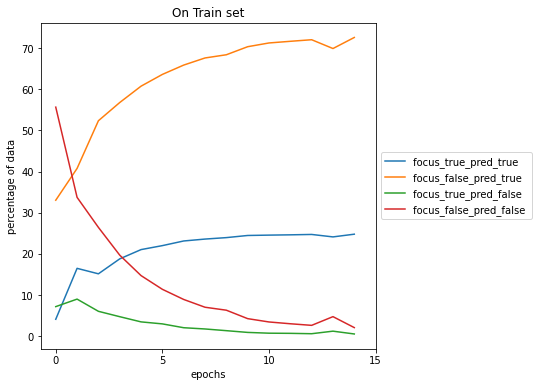

In [25]:
fig= plt.figure(figsize=(6,6))
plt.plot(df_train[columns[0]],df_train[columns[3]], label ="focus_true_pred_true ")
plt.plot(df_train[columns[0]],df_train[columns[4]], label ="focus_false_pred_true ")
plt.plot(df_train[columns[0]],df_train[columns[5]], label ="focus_true_pred_false ")
plt.plot(df_train[columns[0]],df_train[columns[6]], label ="focus_false_pred_false ")
plt.title("On Train set")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xticks([0,5,10,15])
plt.xlabel("epochs")
plt.ylabel("percentage of data")
#plt.vlines(vline_list,min(min(df_train[columns[3]]/300),min(df_train[columns[4]]/300),min(df_train[columns[5]]/300),min(df_train[columns[6]]/300)), max(max(df_train[columns[3]]/300),max(df_train[columns[4]]/300),max(df_train[columns[5]]/300),max(df_train[columns[6]]/300)),linestyles='dotted')
plt.show()
fig.savefig("train_analysis.pdf")
fig.savefig("train_analysis.png")

In [21]:
aph = []
for i in bg:
  aph.append(F.softmax(i,dim=1).detach().numpy())
  
aph = np.concatenate(aph,axis=0)
torch.save({
            'epoch': 500,
            'model_state_dict': what_net.state_dict(),
            #'optimizer_state_dict': optimizer_what.state_dict(),
            "optimizer_alpha":optim1,
            "FTPT_analysis":analysis_data_tr,
            "alpha":aph

            }, "cifar_what_net_500.pt")

In [22]:
aph

array([[0.14277558, 0.1548624 , 0.08149783, ..., 0.12054335, 0.10526688,
        0.08640599],
       [0.13155496, 0.08772316, 0.09479479, ..., 0.0862845 , 0.12993719,
        0.10002434],
       [0.07664876, 0.07064024, 0.06551272, ..., 0.17272697, 0.08176455,
        0.16572993],
       ...,
       [0.17487934, 0.06494422, 0.08183853, ..., 0.15312982, 0.13788116,
        0.1703984 ],
       [0.10411831, 0.15032284, 0.12867457, ..., 0.10479332, 0.08206951,
        0.07571405],
       [0.09378032, 0.1122177 , 0.14243266, ..., 0.08387724, 0.1458779 ,
        0.08383223]], dtype=float32)

In [23]:
running_loss_tr,anls_data,correct,total,accuracy = calculate_attn_loss(train_loader,what_net,criterion)

In [24]:
print("argmax>0.5",anls_data[-2])

argmax>0.5 0
